In [9]:
import os
from matplotlib import pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import DataLoader

from torchvision import datasets, transforms, models

# Dataset

In [15]:
htf = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean = (0.5, 0.5, 0.5), std = (0.5, 0.5, 0.5))
])

train_dir = './data/hymenoptera_data/train'
test_dir = './data/hymenoptera_data/val'

train_data = datasets.ImageFolder(root=train_dir, transform=htf)
test_data = datasets.ImageFolder(root=test_dir, transform=htf)

batchSize = 4
torch.manual_seed(42)

train_loader = DataLoader(train_data, batchSize, shuffle=True)
test_loader = DataLoader(test_data, batchSize, shuffle=False)

In [16]:
print(len(train_data), len(test_data))
print(train_data[0][0].shape)

244 153
torch.Size([3, 224, 224])


In [26]:
model = models.alexnet(weights = models.AlexNet_Weights.DEFAULT)
print(model)
model.classifier[6] = nn.Linear(4096, 2, bias=True)

for param in model.parameters():
    param.requires_grad = False

for param in model.classifier[6].parameters():
    param.requires_grad = True
    
print(model)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [27]:
print("Total trainable parameters:", sum(p.numel() for p in model.parameters() if p.requires_grad))

Total trainable parameters: 8194


In [28]:
epochs = 10
optimizer = torch.optim.Adam(model.parameters(), lr = 0.0001)
criterion = nn.CrossEntropyLoss()


In [29]:
import torch
import torch.nn as nn
import torch.optim as optim

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

loss_list = []
val_loss_list = []
accuracy_list = []
val_accuracy_list = []

epochs = 10

for ep in range(epochs):
    running_loss = 0
    r_corr = 0
    total = 0

    model.train()

    for input, label in train_loader:
        input, label = input.to(device), label.to(device)

        out = model(input)
        loss = criterion(out, label)
        running_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        r_corr += (out.argmax(1) == label).sum().item()
        total += label.size(0)

    tl = running_loss / len(train_loader)
    ta = (r_corr / total) * 100
    loss_list.append(tl)
    accuracy_list.append(ta)

    running_loss = 0
    r_corr = 0
    total = 0

    model.eval()

    with torch.no_grad():
        for input, label in test_loader:
            input, label = input.to(device), label.to(device)
            out = model(input)

            running_loss += criterion(out, label).item()
            r_corr += (out.argmax(1) == label).sum().item()
            total += label.size(0)

    val_loss = running_loss / len(test_loader)
    val_acc = (r_corr / total) * 100
    val_loss_list.append(val_loss)
    val_accuracy_list.append(val_acc)

    print(f"Ep {ep+1}/{epochs}: TrainLoss = {tl:.4f}, TrainAcc = {ta:.2f}%, ValLoss = {val_loss:.4f}, ValAcc = {val_acc:.2f}%")


Ep 1/10: TrainLoss = 0.6399, TrainAcc = 62.70%, ValLoss = 0.4225, ValAcc = 79.08%
Ep 2/10: TrainLoss = 0.3801, TrainAcc = 85.25%, ValLoss = 0.3758, ValAcc = 84.97%
Ep 3/10: TrainLoss = 0.3127, TrainAcc = 88.11%, ValLoss = 0.3110, ValAcc = 86.93%
Ep 4/10: TrainLoss = 0.2501, TrainAcc = 92.62%, ValLoss = 0.3018, ValAcc = 87.58%
Ep 5/10: TrainLoss = 0.2350, TrainAcc = 92.21%, ValLoss = 0.2965, ValAcc = 87.58%
Ep 6/10: TrainLoss = 0.2142, TrainAcc = 93.03%, ValLoss = 0.2765, ValAcc = 90.20%
Ep 7/10: TrainLoss = 0.1935, TrainAcc = 94.26%, ValLoss = 0.2755, ValAcc = 88.89%
Ep 8/10: TrainLoss = 0.1682, TrainAcc = 95.08%, ValLoss = 0.2636, ValAcc = 88.89%
Ep 9/10: TrainLoss = 0.1459, TrainAcc = 95.90%, ValLoss = 0.2769, ValAcc = 87.58%
Ep 10/10: TrainLoss = 0.1358, TrainAcc = 97.54%, ValLoss = 0.2711, ValAcc = 90.20%


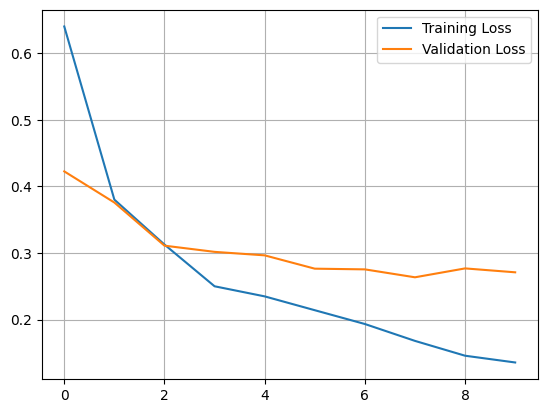

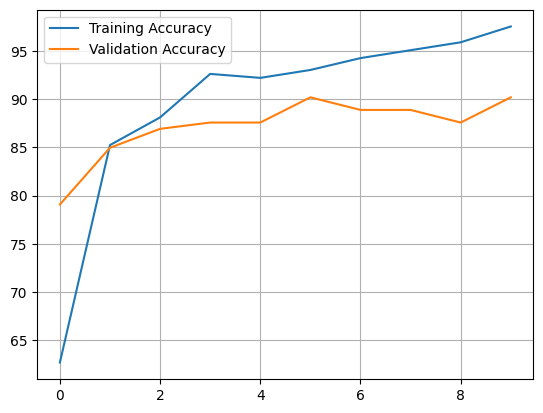

In [32]:
plt.plot(loss_list, label='Training Loss')
plt.plot(val_loss_list, label='Validation Loss')
plt.legend()
plt.grid()
plt.show()

plt.plot(accuracy_list, label='Training Accuracy')
plt.plot(val_accuracy_list, label='Validation Accuracy')
plt.legend()
plt.grid()
plt.show()

In [33]:
# Save the model
torch.save(model.state_dict(), './models/alexnet_hymenoptera.pth')